In [1]:
versioninfo()

Julia Version 1.10.4
Commit 48d4fd48430 (2024-06-04 10:41 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 24 × AMD Ryzen 9 3900X 12-Core Processor
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, znver2)
Threads: 12 default, 0 interactive, 6 GC (on 24 virtual cores)


In [2]:
]instantiate

Precompiling project...
  ✓ Chain
  ✓ RangeArrays
  ✓ Kaleido_jll
  ✓ OpenSSL_jll
  ✓ IndirectArrays
  ✓ PolygonOps
  ✓ Libmount_jll
  ✓ LaTeXStrings
  ✓ PositiveFactorizations
  ✓ AbstractFFTs
  ✓ Calculus
  ✓ Graphite2_jll
  ✓ VaxData
  ✓ StructTypes
  ✓ IteratorInterfaceExtensions
  ✓ Combinatorics
  ✓ ExprTools
  ✓ Glob
  ✓ TensorCore
  ✓ Bzip2_jll
  ✓ WorkerUtilities
  ✓ LazyArtifacts
  ✓ Contour
  ✓ StatsAPI
  ✓ LLVMOpenMP_jll
  ✓ AbstractLattices
  ✓ Lz4_jll
  ✓ CEnum
  ✓ NaturalSort
  ✓ SentinelArrays
  ✓ UnPack
  ✓ libaec_jll
  ✓ IntegerMathUtils
  ✓ Xorg_libXau_jll
  ✓ TriplotBase
  ✓ Rmath_jll
  ✓ RecipesBase
  ✓ libpng_jll
  ✓ OpenLibm_jll
  ✓ ConcurrentUtilities
  ✓ libfdk_aac_jll
  ✓ InverseFunctions
  ✓ Hwloc_jll
  ✓ FillArrays
  ✓ CommonSolve
  ✓ OffsetArrays
  ✓ BufferedStreams
  ✓ CompilerSupportLibraries_jll
  ✓ Imath_jll
  ✓ IntelOpenMP_jll
  ✓ PkgVersion
  ✓ IterTools
  ✓ SuiteSparse_jll
  ✓ SharedArrays
  ✓ LAME_jll
  ✓ WinReg
  ✓ ManualMemory
  ✓ TZJData
  ✓ Shif

In [14]:
]precompile

In [83]:
using Statistics, CSV, DataFrames, DataFramesMeta, StatsBase, HypothesisTests, MixedModels, CategoricalArrays, StandardizedPredictors,
    StatsModels, CairoMakie, MixedModelsExtras, Effects, AlgebraOfGraphics, MixedModelsMakie, Random
CairoMakie.activate!(; type="svg");
MixedModels.ProgressMeter.ijulia_behavior(:clear);

In [5]:
data = CSV.read("../data/data_results.csv", DataFrame);

In [6]:
transform!(data, 
    :subject => (x -> categorical(x; ordered=true, compress=true)),
    :group => (x -> categorical(x; levels=["Control", "PD"], ordered=true, compress=true)),
    :task => (x -> categorical(x; levels=["rrt", "sip"], ordered=true, compress=true)),
    :cued => (x -> categorical(x; ordered=true, compress=true)),
    :session => (x -> categorical(x; ordered=true, compress=true)),
    :meds => (x -> categorical(x; levels=["OFF", "ON"], ordered=true, compress=true)),
    :group_meds => (x -> categorical(x; levels=["Control", "PD_OFF", "PD_ON"], ordered=true, compress=true))
    ; renamecols=false);

In [7]:
vars = [ "cue_bpm", "act_bpm", "bpm_diff", "bpm_err", "numfog", "numsteps",
    "step_time_asym", "clock_var",
    "motor_var", "lag1_corr", "la_step_time_cov", "ma_step_time_cov", "step_time_cov_asym",
    "pci" ];
all_vars = [vars; "la_step_time"; "left_step_time"; "left_step_time_cov"; "ma_step_time"; "right_step_time"; "right_step_time_cov" ];

In [8]:
wide = unstack(data)

@rtransform!(wide, :bpm_err = (:act_bpm - :cue_bpm)/:cue_bpm*100, :bpm_diff = (:act_bpm - :cue_bpm))
@rtransform!(wide, :step_time_asym = ((60*1000)/:ma_step_time - (60*1000)/:la_step_time)/:cue_bpm*100)
allowmissing!(wide, :step_time_asym)
transform!(subset(wide, :group => x -> x .== "Control"; view=true), 
    [:ma_step_time_cov, :la_step_time_cov] => ByRow((ma, la) -> (mean([ma, la]), mean([ma, la]))) => [:ma_step_time_cov, :la_step_time_cov];
    renamecols=false)

rrtdata = @subset(wide, :task .== "rrt")
sipdata = @subset(wide, :task .== "sip");

In [9]:
# Removing egregious outliers
## RRT
outliers = subset(rrtdata, :subject => x -> x .== 26, :meds => x -> x .== "OFF"; view=true)
outliers[:, ["step_time_asym", "clock_var", "motor_var", "lag1_corr", "la_step_time_cov", "pci"]] .= missing

## SIP
outliers = subset(sipdata, :subject => x -> x .== 9; view=true) # Both sessions
outliers[:, ["clock_var", "motor_var", "lag1_corr", "la_step_time_cov", "ma_step_time_cov", "pci"]] .= missing

outliers = subset(sipdata, :subject => x -> x .== 11, :meds => x -> x .== "OFF"; view=true)
outliers[:, ["step_time_asym", "clock_var", "motor_var", "lag1_corr", "la_step_time_cov", "ma_step_time_cov", "pci"]] .= missing

outliers = subset(sipdata, :subject => x -> x .== 15, :meds => x -> x .== "OFF"; view=true)
outliers[:, ["clock_var", "motor_var", "lag1_corr", "la_step_time_cov", "ma_step_time_cov", "pci"]] .= missing;

outliers = subset(sipdata, :subject => x -> x .== 32, :meds => x -> x .== "OFF"; view=true)
outliers[:, ["clock_var", "motor_var", "lag1_corr", "la_step_time_cov", "ma_step_time_cov"]] .= missing;

outliers = subset(sipdata, :subject => x -> x .== 37, :meds => x -> x .== "ON", :cued => x -> x .== false; view=true)
outliers[:, ["clock_var", "motor_var", "lag1_corr"]] .= missing;

outliers = subset(sipdata, :subject => x -> x .== 39, :session => x -> x .== 1; view=true)
outliers[:, ["clock_var", "motor_var", "lag1_corr", "la_step_time_cov", "ma_step_time_cov", "pci"]] .= missing;

In [10]:
contrasts = Dict{Symbol,Any}()
contrasts[:subject] = Grouping()
contrasts[:sample] = Grouping()
contrasts[:session] = Grouping()
contrasts[:group] = DummyCoding(; base="Control")
contrasts[:meds] = DummyCoding(; base="OFF")
contrasts[:group_meds] = HypothesisCoding([-2 1 1; 0 -1 1]; levels=["Control", "PD_OFF", "PD_ON"], labels=["PD vs Control", "PD_ON vs PD_OFF"])
contrasts[:cued] = DummyCoding(; base=false);

In [11]:
clockvar_rrt_lmm = let
    lmtmp = fit(MixedModel,
        @formula(clock_var ~ 1 + group_meds * cued + (1|subject)),
        rrtdata; contrasts)
    print(lmtmp)
    lmtmp
end;

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/dMfiC/src/ProgressMeter.jl:594
Minimizing 13    Time: 0:00:00 (59.72 ms/it)


Linear mixed model fit by maximum likelihood
 clock_var ~ 1 + group_meds + cued + group_meds & cued + (1 | subject)
   logLik   -2 logLik     AIC       AICc        BIC    
   411.1094  -822.2187  -806.2187  -805.0667  -783.0360

Variance components:
            Column    Variance   Std.Dev.  
subject  (Intercept)  0.00004105 0.00640718
Residual              0.00009854 0.00992663
 Number of obs: 134; levels of grouping factors: 37

  Fixed-effects parameters:
──────────────────────────────────────────────────────────────────────────────────
                                                Coef.  Std. Error      z  Pr(>|z|)
──────────────────────────────────────────────────────────────────────────────────
(Intercept)                                0.0106102   0.00161698   6.56    <1e-10
group_meds: PD vs Control                  0.0171346   0.00694215   2.47    0.0136
group_meds: PD_ON vs PD_OFF                0.0089529   0.00298246   3.00    0.0027
cued: true                             

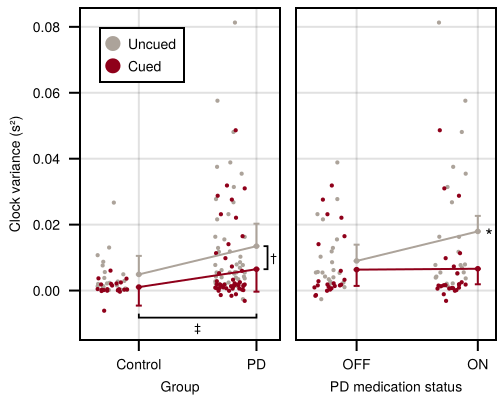

In [110]:
let variable = :clock_var, _data = @subset(rrtdata, .!ismissing.($variable)), lmm = clockvar_rrt_lmm, ylabel="Clock variance (s²)"
    Random.seed!(0xBEEF)
    fg = Figure(;size=(252.283,200), px_per_unit=6.25, pt_per_unit=1, fontsize=7, figure_padding=4)
    axleft = Axis(fg[1,1]; ylabel="Clock variance (s²)", xlabel="Group", xticks=(1:2, ["Control", "PD"]))
    axright = Axis(fg[1,2]; xlabel="PD medication status", xticks=(1:2, ["OFF", "ON"]))
    linkyaxes!(axleft, axright)
    hideydecorations!(axright; grid=false)

    group_cued = let emm = emmeans(clockvar_rrt_lmm)
        gd = groupby(@subset(emm, occursin.(r"^PD", :group_meds)), :cued)
        pd = @combine(gd, :group = "PD", :clock_var = mean(:clock_var), :err = Effects.pooled_sem(:err...))
        ctrl = @rename(@subset(emm, :group_meds .== "Control"), :group = :group_meds)
        cpd = vcat(ctrl, pd)
        @transform(cpd, 
            :cued = categorical(:cued),
            :group = categorical(:group; ordered=true, levels=["Control", "PD"]),
             # Cued is lower, only have downward arrows for cued; vice versa for uncued
            :lower = ifelse.(:cued, :clock_var .- 1.96*:err, :clock_var),
            :upper = ifelse.(:cued, :clock_var, :clock_var .+ 1.96*:err))
    end

    # Add raincloud (jittered categorical scatter plot)
    aog_p = AlgebraOfGraphics.data(_data) * mapping(:group, variable; color=:cued) *
        visual(RainClouds; plot_boxplots=false, clouds=nothing, side=:right, markersize=3, 
        jitter_width=0.25, gap=0, side_nudge=0.225, xlabel="Group", ylabel)

    # Add CI error bars
    aog_p += AlgebraOfGraphics.data(group_cued) *
        mapping(:group, :lower, :upper; color=:cued) *
        (visual(Rangebars; linewidth=1, whiskerwidth=3))
    # Add larger dots for the mean group values
    aog_p += AlgebraOfGraphics.data(group_cued) *
        mapping(:group, variable; color=:cued) *
        (visual(Scatter; markersize=4,) + visual(Lines; linewidth=1))

    # Add significance brackets
    avgs = @subset(group_cued, :group .== "PD")[!, :clock_var]
    bracket!(axleft, 2.06, avgs[1], 2.06, avgs[2]; text = "†", fontsize=6, rotation=0, style=:square, width=2,
        linewidth=0.9, textoffset=3)
    bracket!(axleft, 1, -0.007, 2, -0.007; text = "‡", fontsize=6, style=:square, width=2, linewidth=0.9, textoffset=5,
        orientation=:down)
    
    draw!(axleft, aog_p; palettes=(color=[true => colorant"#8F001A", false => colorant"#ACA39A"],))

    pd = let emm = emmeans(clockvar_rrt_lmm)
        pd = @subset(emm, occursin.(r"^PD", :group_meds))
        @transform(pd, :cued = categorical(:cued),
            :meds = categorical(ifelse.(:group_meds .== "PD_ON", "ON", "OFF"); ordered=true, levels=["OFF", "ON"]),
            :lower = ifelse.(:cued, :clock_var .- 1.96*:err, :clock_var),
            :upper = ifelse.(:cued, :clock_var, :clock_var .+ 1.96*:err))
    end

    # Add raincloud (jittered categorical scatter plot)
    aog_p = AlgebraOfGraphics.data(@subset(_data, :group .== "PD")) * 
        mapping(:meds, variable; color=:cued) *
        visual(RainClouds; plot_boxplots=false, clouds=nothing, side=:right, markersize=3,
        jitter_width=0.25, gap=0, side_nudge=0.225, xlabel="PD medication status")

    # Add CI error bars
    aog_p += AlgebraOfGraphics.data(pd) *
        mapping(:meds, :lower, :upper; color=:cued) *
        (visual(Rangebars; linewidth=1, whiskerwidth=3))

    # Add larger dots for the mean group values
    aog_p += AlgebraOfGraphics.data(pd) *
        mapping(:meds, variable; color=:cued) *
        (visual(Scatter; markersize=4,) + visual(Lines; linewidth=1))

    # Add post-hoc significance indicator
    text!(axright, 2.06, only(@subset(pd, :meds .== "ON", :cued .== false)[!, :clock_var]);
        text = "∗", fontsize=8, align=(:left, :center), offset=(0,1))
    
    draw!(axright, aog_p; palettes=(color=[true => colorant"#8F001A", false => colorant"#ACA39A"],))
    
    Legend(fg[1,1], [
            MarkerElement(color=colorant"#ACA39A", marker='●', markersize=10),
            MarkerElement(color=colorant"#8F001A", marker='●', markersize=10)
        ], ["Uncued", "Cued"];
        tellheight = false,
        tellwidth = false,
        padding=4, patchsize=(5,5), halign=:left, valign=:top, margin=(10,10,10,10))
    
    colgap!(fg.layout, Relative(0.04))
    colsize!(fg.layout, 1, Auto())
    xlims!(axleft, 0.5, 2.2)
    ylims!(axright; low=-0.015)
    xlims!(axright, 0.5, 2.15)
    
    save("$(variable)_rrt.eps", fg; size=(252.283,200), px_per_unit=6.25, pt_per_unit=1)
    save("$(variable)_rrt.png", fg; size=(252.283,200), px_per_unit=6.25, pt_per_unit=1)
    fg
end

In [84]:
lag1corr_rrt_lmm = let
    lmtmp = fit(MixedModel,
        @formula(lag1_corr ~ 1 + group_meds * cued + zerocorr(0+cued|subject) + zerocorr(1+group_meds|sample)),
        rrtdata; contrasts)
    print(lmtmp)
    lmtmp
end;

Linear mixed model fit by maximum likelihood
 lag1_corr ~ 1 + group_meds + cued + group_meds & cued + zerocorr(0 + cued | subject) + zerocorr(1 + group_meds | sample)
   logLik   -2 logLik     AIC       AICc        BIC    
    -5.5467    11.0933    35.0933    37.6719    69.8674

Variance components:
                    Column           Variance Std.Dev.   Corr.
sample   (Intercept)                  0.014264 0.119432
         group_meds: PD vs Control    0.021448 0.146451   .  
         group_meds: PD_ON vs PD_OFF  0.018672 0.136644   .     .  
subject  cued: false                  0.009827 0.099130
         cued: true                   0.025179 0.158679   .  
Residual                              0.033232 0.182297
 Number of obs: 134; levels of grouping factors: 66, 37

  Fixed-effects parameters:
─────────────────────────────────────────────────────────────────────────────────
                                               Coef.  Std. Error      z  Pr(>|z|)
───────────────────────────

In [85]:
lag1corr_sip_lmm = let
    lmtmp = fit(MixedModel,
        @formula(lag1_corr ~ 1 + group_meds*cued + (1|subject)),
        sipdata; contrasts)
    print(lmtmp)
    lmtmp
end;

Linear mixed model fit by maximum likelihood
 lag1_corr ~ 1 + group_meds + cued + group_meds & cued + (1 | subject)
   logLik   -2 logLik     AIC       AICc        BIC    
    28.3113   -56.6226   -40.6226   -39.3595   -18.1252

Variance components:
            Column   Variance Std.Dev. 
subject  (Intercept)  0.022640 0.150465
Residual              0.024701 0.157167
 Number of obs: 123; levels of grouping factors: 35

  Fixed-effects parameters:
──────────────────────────────────────────────────────────────────────────────────
                                                Coef.  Std. Error      z  Pr(>|z|)
──────────────────────────────────────────────────────────────────────────────────
(Intercept)                               -0.191422     0.0328229  -5.83    <1e-08
group_meds: PD vs Control                 -0.364114     0.140242   -2.60    0.0094
group_meds: PD_ON vs PD_OFF               -0.00230568   0.0508283  -0.05    0.9638
cued: true                                -0.072847

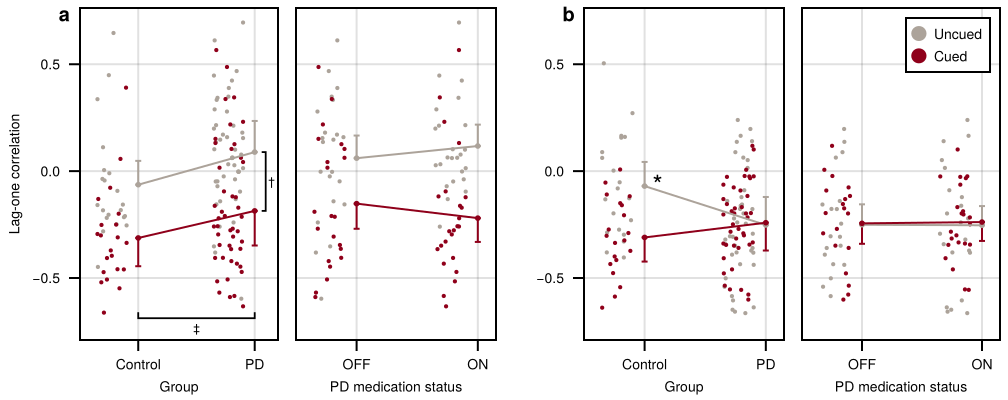

In [113]:
let variable = :lag1_corr, ylabel="Lag-one correlation"
    Random.seed!(0xBEEF)
    _rrtdata = @subset(rrtdata, .!ismissing.($variable))
    rrtlmm = lag1corr_rrt_lmm
    
    _sipdata = @subset(sipdata, .!ismissing.($variable))
    siplmm = lag1corr_sip_lmm
    
    fg = Figure(;size=(504,200), px_per_unit=6.25, pt_per_unit=1, fontsize=7, figure_padding=4)
    axrrt_group = Axis(fg[1,1]; ylabel="Lag-one correlation", xlabel="Group", xticks=(1:2, ["Control", "PD"]))
    axrrt_meds = Axis(fg[1,2]; xlabel="PD medication status", xticks=(1:2, ["OFF", "ON"]))
    axsip_group = Axis(fg[1,3]; xlabel="Group", xticks=(1:2, ["Control", "PD"]))
    axsip_meds = Axis(fg[1,4]; xlabel="PD medication status", xticks=(1:2, ["OFF", "ON"]))
    linkyaxes!(axrrt_group, axrrt_meds, axsip_group, axsip_meds)
    hideydecorations!(axrrt_meds; grid=false)
    hideydecorations!(axsip_group; ticklabels = false, ticks = false, grid=false)
    hideydecorations!(axsip_meds; grid=false)

    group_cued = let emm = emmeans(rrtlmm)
        gd = groupby(@subset(emm, occursin.(r"^PD", :group_meds)), :cued)
        pd = @combine(gd, :group = "PD", $variable = mean($variable), :err = Effects.pooled_sem(:err...))
        ctrl = @rename(@subset(emm, :group_meds .== "Control"), :group = :group_meds)
        cpd = vcat(ctrl, pd)
        @transform(cpd, 
            :cued = categorical(:cued),
            :group = categorical(:group; ordered=true, levels=["Control", "PD"]),
            :lower = ifelse.(:cued, $variable .- 1.96*:err, $variable),
            :upper = ifelse.(:cued, $variable, $variable .+ 1.96*:err))
    end
    
    aog_p = AlgebraOfGraphics.data(_rrtdata) *
        mapping(:group, variable; color=:cued) *
        visual(RainClouds; plot_boxplots=false, clouds=nothing, side=:right, markersize=3, 
            jitter_width=0.25, gap=0, side_nudge=0.225, xlabel="Group", ylabel)

    aog_p += AlgebraOfGraphics.data(group_cued) *
        mapping(:group, :lower, :upper; color=:cued) *
        (visual(Rangebars; linewidth=1, whiskerwidth=3))
    aog_p += AlgebraOfGraphics.data(group_cued) *
        mapping(:group, variable; color=:cued) *
        (visual(Scatter; markersize=4,) + visual(Lines; linewidth=1))
    
    # Add significance brackets
    avgs = @subset(group_cued, :group .== "PD")[!, :lag1_corr]
    bracket!(axrrt_group, 2.06, avgs[1], 2.06, avgs[2]; text = "†", fontsize=6, rotation=0, style=:square, width=2,
        linewidth=0.9, textoffset=3)
    bracket!(axrrt_group, 1, -0.66, 2, -0.66; text = "‡", fontsize=6, style=:square, width=3, linewidth=0.9, textoffset=5,
        orientation=:down)
    
    draw!(axrrt_group, aog_p; palettes=(color=[true => colorant"#8F001A", false => colorant"#ACA39A"],))

    pd = let emm = emmeans(rrtlmm)
        pd = @subset(emm, occursin.(r"^PD", :group_meds))
        @transform(pd, :cued = categorical(:cued),
            :meds = categorical(ifelse.(:group_meds .== "PD_ON", "ON", "OFF"); ordered=true, levels=["OFF", "ON"]),
            :lower = ifelse.(:cued, $variable .- 1.96*:err, $variable),
            :upper = ifelse.(:cued, $variable, $variable .+ 1.96*:err))
    end
    
    aog_p = AlgebraOfGraphics.data(@subset(_rrtdata, :group .== "PD")) * 
        mapping(:meds, variable; color=:cued) *
        visual(RainClouds; plot_boxplots=false, clouds=nothing, side=:right, markersize=3,
        jitter_width=0.25, gap=0, side_nudge=0.225, xlabel="PD medication status")
    aog_p += AlgebraOfGraphics.data(pd) *
        mapping(:meds, :lower, :upper; color=:cued) *
        (visual(Rangebars; linewidth=1, whiskerwidth=3))
    aog_p += AlgebraOfGraphics.data(pd) *
        mapping(:meds, variable; color=:cued) *
        (visual(Scatter; markersize=4,) + visual(Lines; linewidth=1))
    draw!(axrrt_meds, aog_p; palettes=(color=[true => colorant"#8F001A", false => colorant"#ACA39A"],))

    group_cued = let emm = emmeans(siplmm)
        gd = groupby(@subset(emm, occursin.(r"^PD", :group_meds)), :cued)
        pd = @combine(gd, :group = "PD", $variable = mean($variable), :err = Effects.pooled_sem(:err...))
        ctrl = @rename(@subset(emm, :group_meds .== "Control"), :group = :group_meds)
        cpd = vcat(ctrl, pd)
        @transform(cpd, 
            :cued = categorical(:cued),
            :group = categorical(:group; ordered=true, levels=["Control", "PD"]),
            :lower = ifelse.(:cued, $variable .- 1.96*:err, $variable),
            :upper = ifelse.(:cued, $variable, $variable .+ 1.96*:err))
    end
    
    aog_p = AlgebraOfGraphics.data(_sipdata) *
        mapping(:group, variable; color=:cued) *
        visual(RainClouds; plot_boxplots=false, clouds=nothing, side=:right, markersize=3, 
            jitter_width=0.25, gap=0, side_nudge=0.225, xlabel="Group", ylabel)

    aog_p += AlgebraOfGraphics.data(group_cued) *
        mapping(:group, :lower, :upper; color=:cued) *
        (visual(Rangebars; linewidth=1, whiskerwidth=3))
    aog_p += AlgebraOfGraphics.data(group_cued) *
        mapping(:group, variable; color=:cued) *
        (visual(Lines; linewidth=1) + visual(Scatter; markersize=4,))

    # Add post-hoc significance indicator
    text!(axsip_group, 1.06, only(@subset(group_cued, :group .== "Control", :cued .== false)[!, :lag1_corr]);
        text = "∗", fontsize=11, align=(:left, :center), offset=(0,5))
    
    draw!(axsip_group, aog_p; palettes=(color=[true => colorant"#8F001A", false => colorant"#ACA39A"],))

    pd = let emm = emmeans(siplmm)
        pd = @subset(emm, occursin.(r"^PD", :group_meds))
        @transform(pd, :cued = categorical(:cued),
            :meds = categorical(ifelse.(:group_meds .== "PD_ON", "ON", "OFF"); ordered=true, levels=["OFF", "ON"]),
            :lower = ifelse.(:cued, $variable .- 1.96*:err, $variable),
            :upper = ifelse.(:cued, $variable, $variable .+ 1.96*:err))
    end
    
    aog_p = AlgebraOfGraphics.data(@subset(_sipdata, :group .== "PD")) * 
        mapping(:meds, variable; color=:cued) *
        visual(RainClouds; plot_boxplots=false, clouds=nothing, side=:right, markersize=3,
        jitter_width=0.25, gap=0, side_nudge=0.225, xlabel="PD medication status")
    aog_p += AlgebraOfGraphics.data(pd) *
        mapping(:meds, :lower, :upper; color=:cued) *
        (visual(Rangebars; linewidth=1, whiskerwidth=3))
    aog_p += AlgebraOfGraphics.data(pd) *
        mapping(:meds, variable; color=:cued) *
        (visual(Lines; linewidth=1) + visual(Scatter; markersize=4,))
    
    grid = draw!(axsip_meds, aog_p; palettes=(color=[true => colorant"#8F001A", false => colorant"#ACA39A"],))

    Legend(fg[1,4], [
            MarkerElement(color=colorant"#ACA39A", marker='●', markersize=10),
            MarkerElement(color=colorant"#8F001A", marker='●', markersize=10)
        ], ["Uncued", "Cued"];
        tellheight = false,
        tellwidth = false,
        padding=4, patchsize=(5,5), halign=:right, valign=:top, margin=(10,5,5,5))
    
    colgap!(fg.layout, 1, Relative(0.02))
    colgap!(fg.layout, 2, Relative(0.05))
    colgap!(fg.layout, 3, Relative(0.02))
    colsize!(fg.layout, 1, Auto())
    xlims!(axrrt_group, 0.5, 2.2)
    xlims!(axrrt_meds, 0.5, 2.15)
    ylims!(axsip_meds; low=-0.79)
    xlims!(axsip_group, 0.5, 2.15)
    xlims!(axsip_meds, 0.5, 2.15)

    Label(fg.layout[1, 1, TopLeft()], "a",
        tellheight=false,
        fontsize = 10,
        font = :bold,
        padding = (10, 5, 5, 11),
        halign = :right)
    Label(fg.layout[1, 3, TopLeft()], "b",
        tellheight=false,
        fontsize = 10,
        font = :bold,
        padding = (10, 5, 5, 11),
        halign = :right)

    save("$(variable)_rrt_sip.eps", fg; size=(504,200), px_per_unit=6.25, pt_per_unit=1)
    save("$(variable)_rrt_sip.png", fg; size=(504,200), px_per_unit=6.25, pt_per_unit=1)
    fg
end